# K-Clustering using Reinforcement Learning

## DM-Gym prototype testing

### By Ashwin Devanga

#### Import Base Packages

In [1]:
import numpy as np
import pandas as pd

from tqdm import tqdm

import matplotlib.pyplot as plt

#### import datamining gym packages

In [2]:
from dm_gym.utils.data_gen import data_gen_clustering
from dm_gym.create_env import ray_create_env

#### import ray packages for prebuilt RL models

In [3]:
%%capture
import ray
from ray.rllib import agents
from ray import tune

In [4]:
import ray.rllib.agents.dqn as dqn

#### Function to register environment with ray[tune]

In [5]:
def register_env(env_name, env_config={}):
    env = ray_create_env(env_name)
    tune.register_env(env_name, 
        lambda env_name: env(env_name,
            env_config=env_config))

#### If you want to use a custom directory to store ray results. The default directory is root/ray_results/*

In [6]:
from ray.tune.logger import Logger, UnifiedLogger
import os
import datetime
import tempfile

def custom_log_creator(custom_path, custom_str):

    timestr = datetime.datetime.today().strftime("%Y-%m-%d_%H-%M-%S")
    logdir_prefix = "{}_{}".format(custom_str, timestr)

    def logger_creator(config):

        if not os.path.exists(custom_path):
            os.makedirs(custom_path)
        logdir = tempfile.mkdtemp(prefix=logdir_prefix, dir=custom_path)
        return UnifiedLogger(config, logdir, loggers=None)

    return logger_creator

#### Iris Dataset
Load the iris dataset instead of simulated data

In [7]:
import pandas as pd
from sklearn import datasets
import matplotlib.pyplot as plt

iris = datasets.load_iris()
data = pd.DataFrame(data=iris.data)
data.head()

,0,1,2,3
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [8]:
k = 3
num_records = len(data.index)
print(num_records)

150


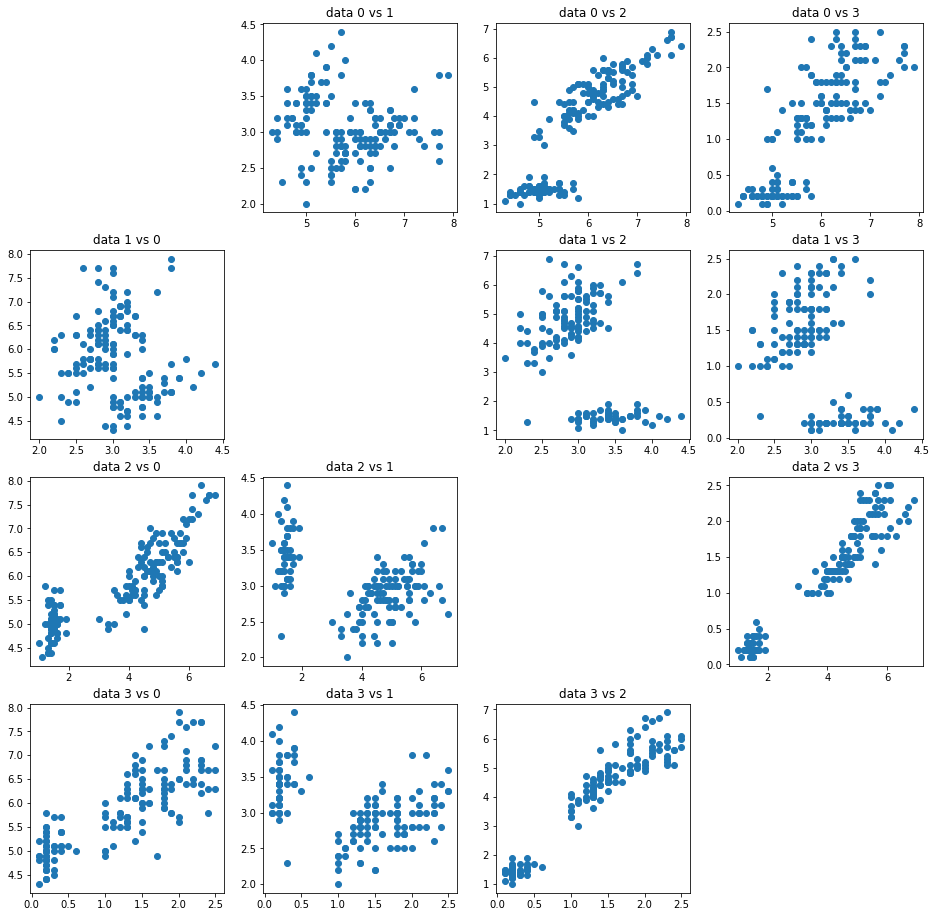

In [9]:
### Plot the data
fig, axs = plt.subplots(4, 4, figsize=(16,16))

for i in range(len(data.columns)):
    for j in range(len(data.columns)):
        if(i!=j):
            axs[i,j].scatter(data[i], data[j])
            axs[i,j].set_title("data "+str(i)+" vs "+str(j))
        if(i==j):
            axs[i,j].axis('off')

plt.savefig("./Results/IMG/Data_Plain_IRIS.svg", dpi=300)
plt.show()

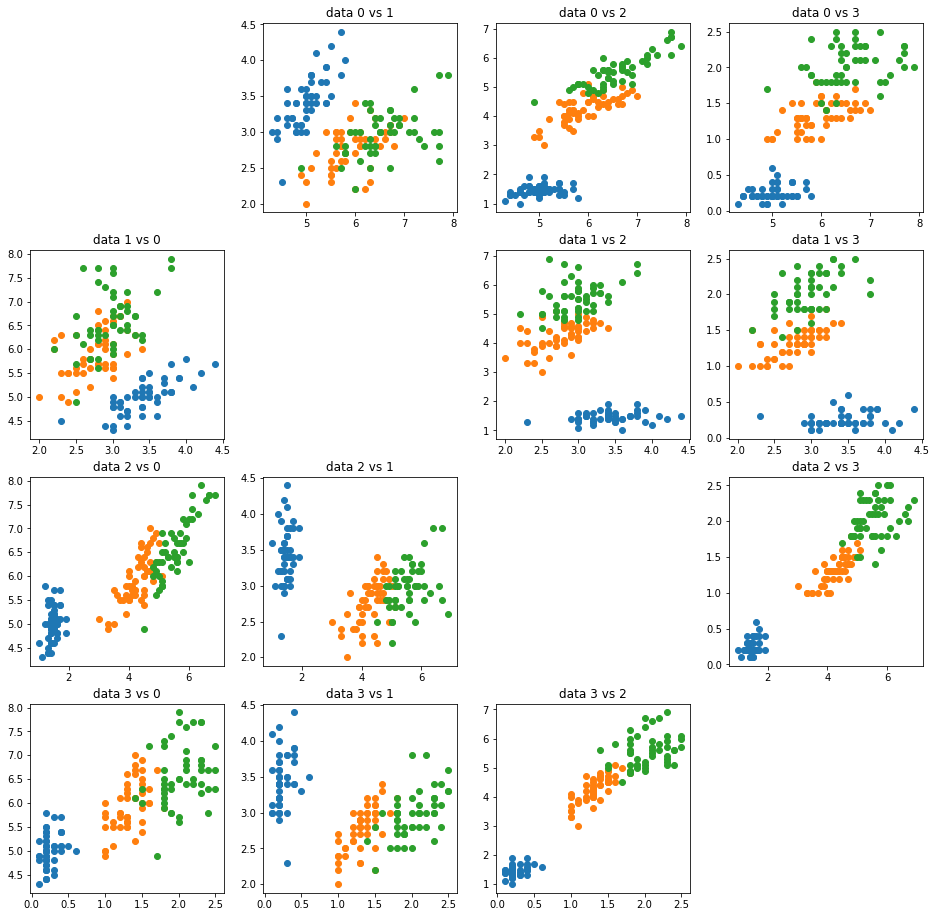

In [10]:
### Plot actual classes
from copy import deepcopy
final_df = deepcopy(data)
final_df['Class'] = iris.target

fig, axs = plt.subplots(4, 4, figsize=(16,16))
for i in range(len(final_df.columns) - 1):
    for j in range(len(final_df.columns) - 1):
        if(i!=j):
            for cls in final_df['Class'].unique():
                axs[i,j].scatter(final_df[final_df['Class'] == cls][i], final_df[final_df['Class'] == cls][j])
                axs[i,j].set_title("data "+str(i)+" vs "+str(j))
        if(i==j):
            axs[i,j].axis('off')

plt.savefig("./Results/IMG/Data_actual_IRIS.svg", dpi=300)
plt.show()

#### Run Mean-Shift model on the data

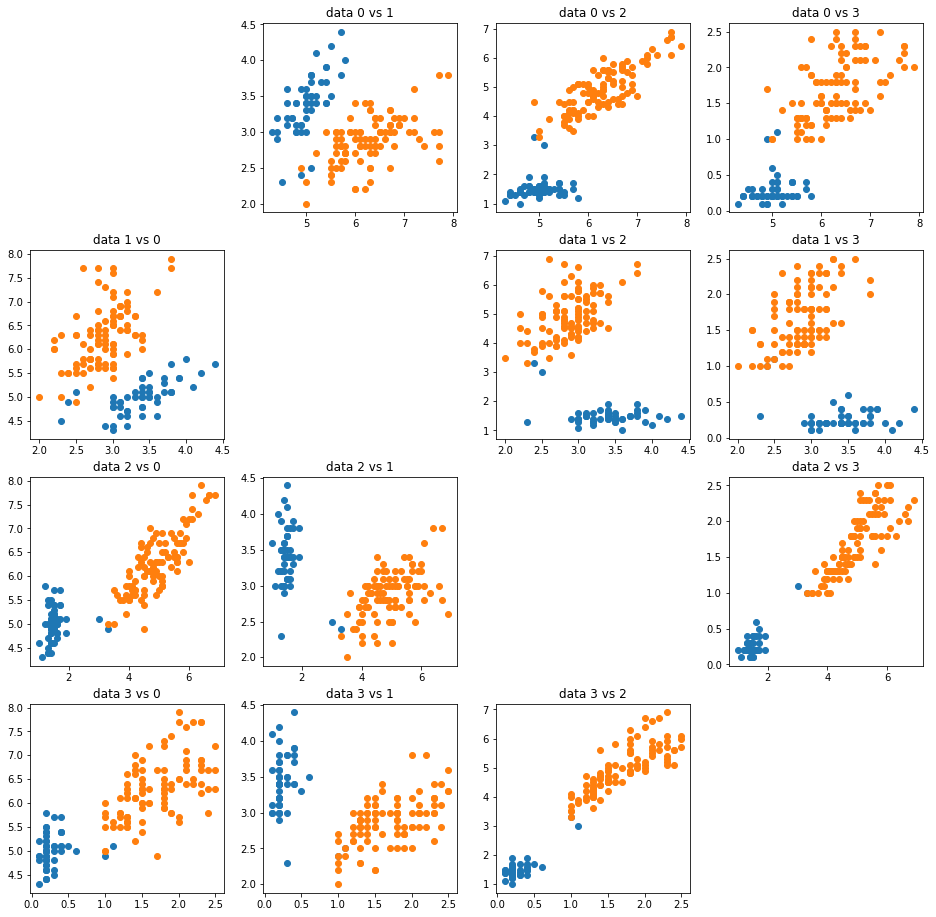

In [11]:
data_gen = data_gen_clustering()

final_df, coords = data_gen.gen_model(data)

fig, axs = plt.subplots(4, 4, figsize=(16,16))
for i in range(len(final_df.columns) - 1):
    for j in range(len(final_df.columns) - 1):
        if(i!=j):
            for cls in final_df['Class'].unique():
                axs[i,j].scatter(final_df[final_df['Class'] == cls][i], final_df[final_df['Class'] == cls][j])
                axs[i,j].set_title("data "+str(i)+" vs "+str(j))
        if(i==j):
            axs[i,j].axis('off')
            
plt.savefig("./Results/IMG/Data_MS_IRIS.svg", dpi=300)
plt.show()

#### Run K-Means clustering model on the data

C:\Users\Ashwin\anaconda3\envs\myenv_ray\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


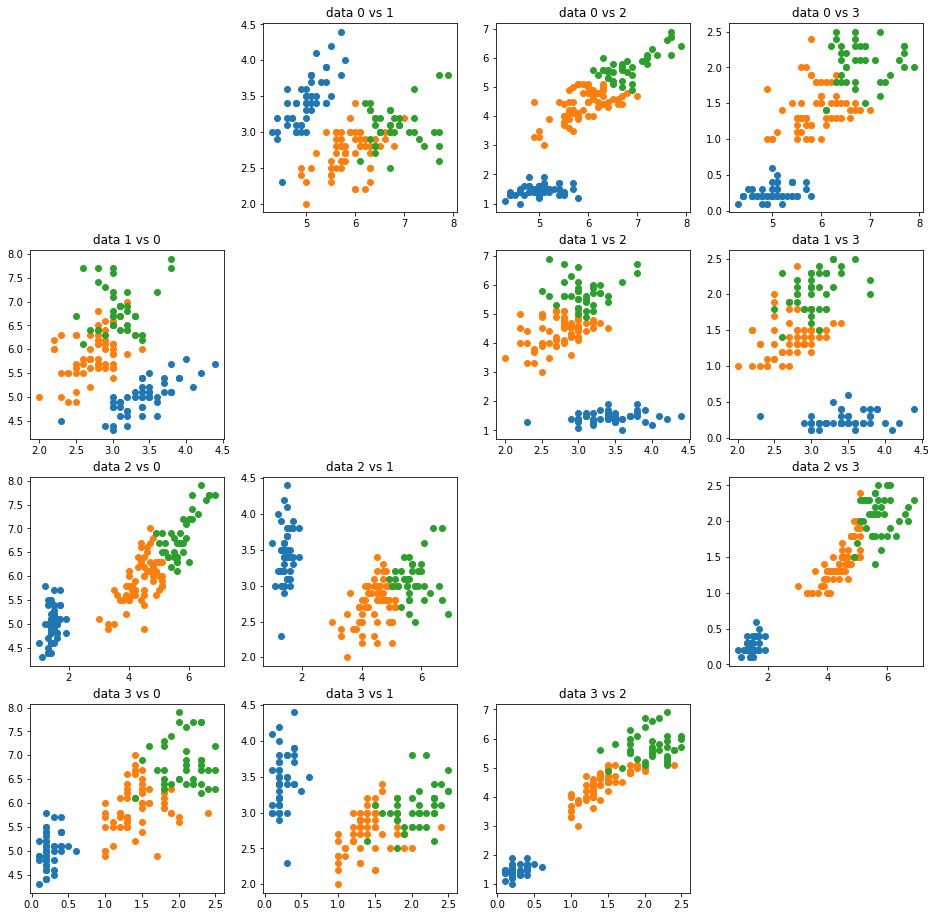

In [12]:
final_df, coords = data_gen.gen_model_Kmeans(data, k)

fig, axs = plt.subplots(4, 4, figsize=(16,16))
for i in range(len(final_df.columns)-1):
    for j in range(len(final_df.columns) - 1):
        if(i!=j):
            for cls in final_df['Class'].unique():
                axs[i,j].scatter(final_df[final_df['Class'] == cls][i], final_df[final_df['Class'] == cls][j])
                axs[i,j].set_title("data "+str(i)+" vs "+str(j))
        if(i==j):
            axs[i,j].axis('off')

plt.savefig("./Results/IMG/Data_KMC_IRIS.svg", dpi=300)
plt.show()

#### Model and environment configurations

In [13]:
env_name = "clustering-v3"

epochs = 500

num_timesteps = 1000

env_config = {
    'data': data,
    'k': k,
}


rl_config = dict(
    log_level = "ERROR",
    env=env_name,
    
    num_workers=10,
    num_gpus=1,
    
    env_config=env_config,

    double_q=True,
    model=dict(
        vf_share_layers=False,
        fcnet_activation='relu',
        fcnet_hiddens=[128, 64]
    ),
    exploration_config={
        "type": "EpsilonGreedy",
        "initial_epsilon": 1.0,
        "final_epsilon": 0.02,
        "epsilon_timesteps": 0.4*num_timesteps*epochs,
    },
    evaluation_config={
        "explore": False,
    },
    gamma = 0.4,
    target_network_update_freq=500,
    buffer_size=100,
    #adam_epsilon=1e-8,
    #grad_clip=40,
    train_batch_size=32,
    framework='torch',
    lr=5e-5
)

#### Train the model 

In [14]:
### Use tensorboard to monitor the training.

# Comment out the below line to use the default ray results directory.
ray_results_dir = "./ray_results"

## On google colab, uncomment this:

#%load_ext tensorboard 
#%tensorboard --logdir ~/ray_results

## To run locally, paste the below command
#  in your terminal to start the server:

#tensorboard --logdir "./ray_results"

In [15]:
# Register environment
ray.shutdown()
register_env(env_name, env_config)

# Initialize Ray and Build Agent
info = ray.init(num_cpus=10, num_gpus=1, ignore_reinit_error=True, log_to_driver=False)
print("Dashboard URL: http://{}".format(info["webui_url"]))

try:
    ## Use this to change the directory where ray results are stored
    agent = agents.dqn.DQNTrainer(env=env_name, config=rl_config, logger_creator=custom_log_creator(os.path.expanduser(ray_results_dir), env_name))
except:
    ## Use this for default ray_results storage
    agent = agents.dqn.DQNTrainer(env=env_name, config=rl_config)


results = []

rew = np.nan

pbar = tqdm(range(epochs), desc='Training Loop' )

for i in pbar:
    res = agent.train()
    results.append(res)
    rew = res['episode_reward_mean']
    pbar.set_description("reward = %f" % rew)
ray.shutdown()

2022-07-28 05:04:29,490	INFO services.py:1470 -- View the Ray dashboard at http://127.0.0.1:8265
C:\Users\Ashwin\AppData\Local\Temp\ipykernel_11756\3311810919.py:7: DeprecationWarning: Accessing values through ctx["webui_url"] is deprecated. Use ctx.address_info["webui_url"] instead.
  print("Dashboard URL: http://{}".format(info["webui_url"]))


Dashboard URL: http://127.0.0.1:8265


2022-07-28 05:04:51,215	INFO trainable.py:159 -- Trainable.setup took 17.377 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
reward = 3.820000: 100%|█████████████████████████████████████████████████████████████| 500/500 [11:00<00:00,  1.32s/it]


#### Plot Rewards

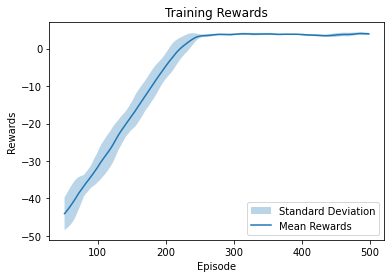

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Unpack values from each iteration
rewards = np.hstack([i['episode_reward_mean'] 
    for i in results])

p = 50
mean_rewards = np.array([np.mean(rewards[i-p:i+1]) 
                if i >= p else np.mean(rewards[:i+1]) 
                for i, _ in enumerate(rewards)])
std_rewards = np.array([np.std(rewards[i-p:i+1])
               if i >= p else np.std(rewards[:i+1])
               for i, _ in enumerate(rewards)])

plt.fill_between(np.arange(len(mean_rewards)), 
                 mean_rewards - std_rewards, 
                 mean_rewards + std_rewards, 
                 label='Standard Deviation', alpha=0.3)
plt.plot(mean_rewards, label='Mean Rewards')
plt.ylabel('Rewards')
plt.xlabel('Episode')
plt.title('Training Rewards')
plt.legend()
plt.show()

#### Plot Loss (td error)

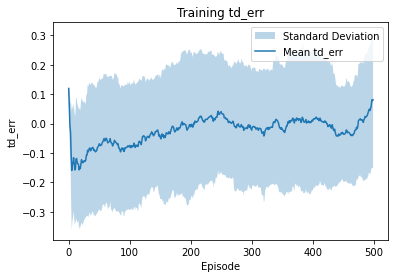

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Unpack values from each iteration
td_err = [
    i['info']['learner']['default_policy']['mean_td_error'] 
    for i in results]

p = 50

mean_td_err = np.array([np.mean(td_err[i-p:i+1]) 
                if i >= p else np.mean(td_err[:i+1]) 
                for i, _ in enumerate(td_err)])
std_td_err = np.array([np.std(td_err[i-p:i+1])
               if i >= p else np.std(td_err[:i+1])
               for i, _ in enumerate(td_err)])

plt.fill_between(np.arange(len(mean_td_err)), 
                 mean_td_err - std_td_err, 
                 mean_td_err + std_td_err, 
                 label='Standard Deviation', alpha=0.3)
plt.plot(mean_td_err, label='Mean td_err')
plt.ylabel('td_err')
plt.xlabel('Episode')
plt.title('Training td_err')
plt.legend()
plt.show()

#### Run the agent through the data to check output

In [18]:
actions = []
observations = []
for i in range(len(data.index)):
    obs = data.iloc[[i]].values.tolist()
    action = agent.compute_action(obs)
    actions.append(action)

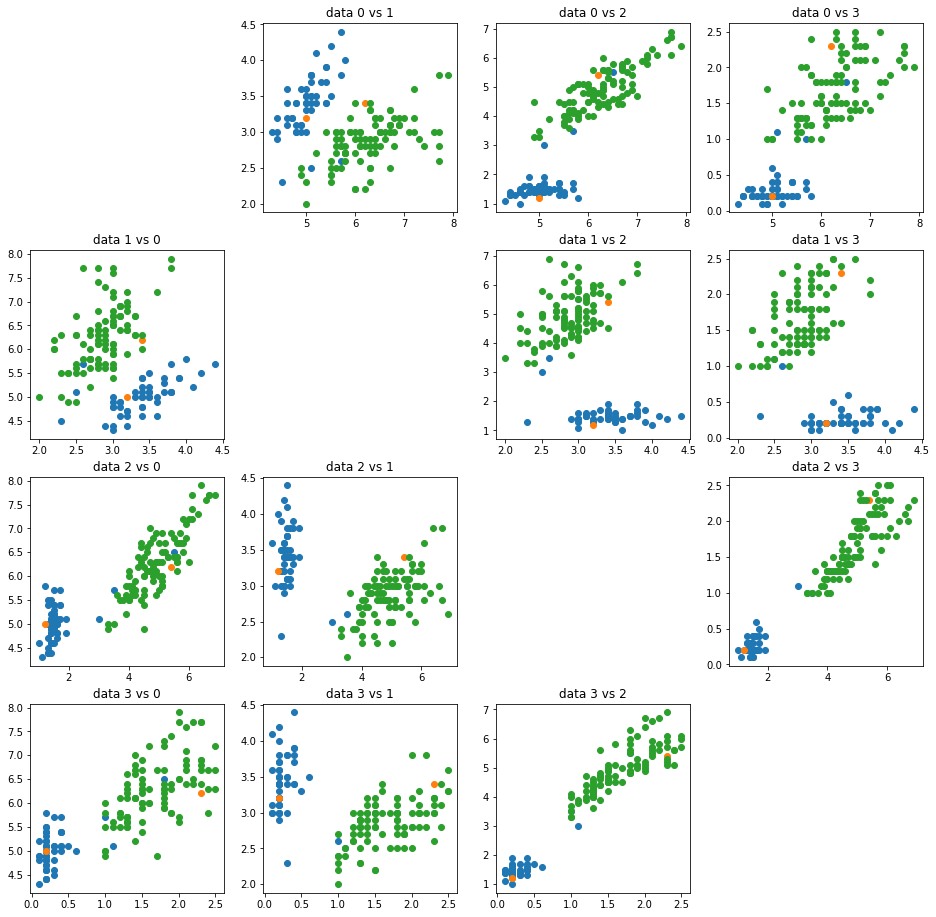

In [19]:
### Plot final output
from copy import deepcopy
final_df = deepcopy(data)
final_df['action'] = actions

fig, axs = plt.subplots(4, 4, figsize=(16,16))
for i in range(len(final_df.columns)-1):
    for j in range(len(final_df.columns) - 1):
        if(i!=j):
            for cls in final_df['action'].unique():
                axs[i,j].scatter(final_df[final_df['action'] == cls][i], final_df[final_df['action'] == cls][j])
                axs[i,j].set_title("data "+str(i)+" vs "+str(j))
        if(i==j):
            axs[i,j].axis('off')

plt.savefig("./Results/IMG/Data_Model_Clustering_v2_IRIS.svg", dpi=300)
plt.show()

In [20]:
import pickle

pickle.dump(rewards, open( "./Results/ClusteringV2_IRIS_rewards.pickle", "wb" ) )
pickle.dump(td_err, open( "./Results/ClusteringV2_IRIS_tderr.pickle", "wb" ) )